# Base Experiment

When the net is not trained it cannot separate corner ideas from non-corner ideas for the fc2 layer
need to test other layers at some point? Or now etc 

In [1]:
from alphazero.arena import Arena
from alphazero.players import RandomPlayer, MCTSPlayer
from alphazero.games.othello import OthelloBoard

def generate_games(n_games=1000, board_size=6):
    """Generate games and collect all positions"""
    positions = []
    
    board = OthelloBoard(n=board_size)
    p1 = RandomPlayer()  # Fast
    p2 = RandomPlayer()
    
    for game_idx in range(n_games):
        board.reset()
        game_positions = []
        
        while not board.is_game_over():
            # Record position
            game_positions.append({
                'grid': board.grid.copy(),
                'player': board.player,
                'move_number': len(game_positions)
            })
            
            # Play move
            if board.player == 1:
                move, _, _, _ = p1.get_move(board)
            else:
                move, _, _, _ = p2.get_move(board)
            board.play_move(move)
        
        positions.extend(game_positions)
    
    return positions

/Users/ayushjain/Development/Research/alphazero/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
positions = generate_games()

In [3]:
def has_corner(grid, player, board_size=6):
    """
    Check if player owns any corner.
    
    Args:
        grid: numpy array of shape (board_size, board_size)
        player: 1 (black) or -1 (white)
        board_size: size of the board
    
    Returns:
        True if player owns at least one corner
    """
    n = board_size
    corners = [(0, 0), (0, n-1), (n-1, 0), (n-1, n-1)]
    
    for row, col in corners:
        if grid[row, col] == player:
            return True
    return False


In [4]:
# Pseudocode structure
X_plus = []  # Positions WITH the concept
X_minus = []  # Positions WITHOUT the concept

for position in positions:
    if has_corner(position['grid'], position['player']):
        X_plus.append(position)
    else:
        X_minus.append(position)

In [5]:
len(X_plus), len(X_minus)

(13431, 19064)

# Activation Hooks

In [6]:
from alphazero.games.othello import OthelloNet

net = OthelloNet(n=6)

In [7]:
net = OthelloNet.from_pretrained("alphazero-othello", "/Users/ayushjain/Development/Research/alphazero/models/")


In [8]:
net

OthelloNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=1024, bias=True)
  (fc_bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_probs): Linear(in_features=512, out_fe

In [9]:
import torch 
import numpy as np 

def extract_layer(net, positions: list[dict], layer_name: str = 'fc2') -> np.ndarray:
    """
    Extract activations from any layer by name.
    """
    net.eval()
    
    activation = {}
    
    def hook_fn(module, input, output):
        activation['value'] = output.detach()
    
    # Get layer by name
    layer = dict(net.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)
    
    # Forward pass
    grids = np.array([p['player'] * p['grid'] for p in positions])
    x = torch.tensor(grids, dtype=torch.float, device=net.device)
    
    with torch.no_grad():
        net(x)
    
    handle.remove()
    
    # Flatten if conv layer (has spatial dims)
    act = activation['value']
    if act.dim() > 2:
        act = act.view(act.size(0), -1)
    
    return act.cpu().numpy()

In [10]:
import cvxpy as cp
import numpy as np

def find_concept_vector(Z_plus: np.ndarray, Z_minus: np.ndarray, margin: float = 0.01):
    """
    Find sparse concept vector via convex optimization.
    
    Args:
        Z_plus: (n_plus, dim) activations for positive class
        Z_minus: (n_minus, dim) activations for negative class  
        margin: minimum separation (v·z⁺ ≥ v·z⁻ + margin)
    
    Returns:
        v: (dim,) concept vector
    """
    n_plus, dim = Z_plus.shape
    n_minus = Z_minus.shape[0]
    
    # Variable we're solving for
    v = cp.Variable(dim)
    
    # Constraints: every positive beats every negative
    constraints = []
    for i in range(n_plus):
        for j in range(n_minus):
            constraints.append(v @ Z_plus[i] >= v @ Z_minus[j] + margin)
    
    # Objective: minimize L1 norm
    objective = cp.Minimize(cp.norm(v, 1))
    
    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    if problem.status == 'optimal':
        return v.value
    else:
        print(f"Optimization failed: {problem.status}")
        return None

In [11]:
positive = extract_layer(net, X_plus)
negative = extract_layer(net, X_minus)

/Users/ayushjain/Development/Research/alphazero/viz_board.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((c, r), 0.38, color='white', edgecolor='black',


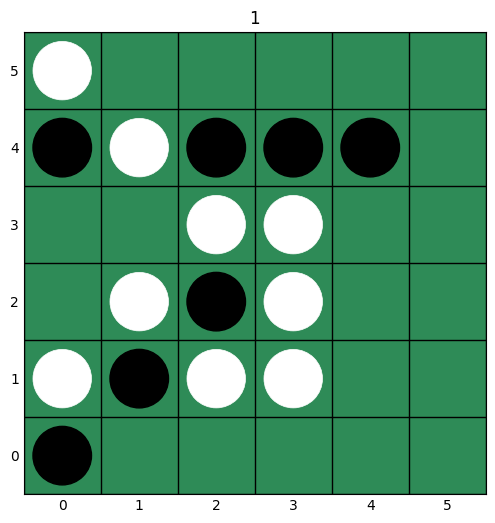

In [17]:
from viz_board import viz_board 
viz_board(X_plus[0]['grid'], X_plus[0]['player'])

In [12]:
positive.shape

(13431, 512)

In [13]:
negative.shape

(19064, 512)

In [14]:
batch_size = 100
v = find_concept_vector(positive[:batch_size], negative[:batch_size])

In [15]:
proj_plus = positive[batch_size+1:batch_size+100] @ v   # Should be high
# Project test data
proj_minus = negative[batch_size+1:batch_size+100] @ v  # Should be low

# Accuracy with threshold=0
acc = (np.sum(proj_plus > 0) + np.sum(proj_minus <= 0)) / (len(proj_plus) + len(proj_minus))

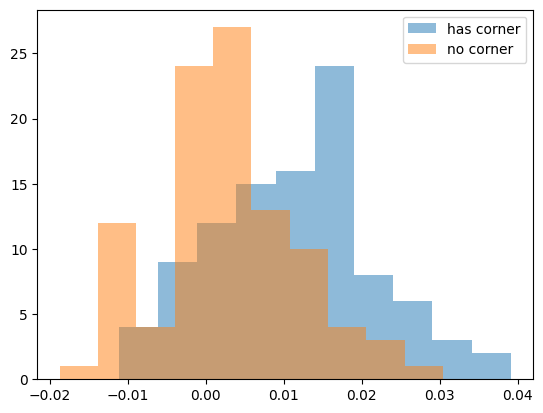

In [16]:
# Visualize separation
import matplotlib.pyplot as plt
plt.hist(proj_plus, alpha=0.5, label='has corner')
plt.hist(proj_minus, alpha=0.5, label='no corner')
plt.legend()
plt.show()